# SVR for CPI prediction

In [3]:
#Necessary Libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, RepeatedKFold, cross_val_score
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error


In [4]:
def preprocess_data(data, lag):    
    # Remove rows with missing values
    data.dropna(inplace=True)
    
    # Create a lagged CPI feature
    column_name = f'CPI {lag} Month{"s" if lag > 1 else ""} ahead'
    data[column_name] = data['CPI'].shift(-lag)
    
    # Remove the 'Year and Month' column
    data.drop('Year and Month', axis=1, inplace=True)
    
    # Scale the features
    scaler = StandardScaler()
    data.iloc[:, :-1] = scaler.fit_transform(data.iloc[:, :-1])
    
    return data, scaler

# Load the dataset
data = pd.read_csv('Monthly_data.csv')

#Lag - how many months ahead we want to predict
lag = 1

# Preprocess the data and save the scaler for later use
data_processed, scaler = preprocess_data(data, lag)

data_processed

,CPI,Interest rate,GDP growth,Total pay nominal,Unemployment,USD/GBP,M3 growth,Brent,12 Month MA - current,CPI 1 Month ahead
11,-0.536837,1.012194,-0.032012,-0.007089,-0.239195,-0.519089,0.085339,-1.795746,-0.047751,1.5
12,-0.536837,1.012194,-0.032012,-0.110672,-0.239195,-0.521700,0.208657,-1.671998,-0.001861,1.4
13,-0.582737,1.012194,0.034806,-0.110672,-0.239195,-0.430763,-0.407937,-1.598545,0.105215,0.8
14,-0.858137,1.012194,0.034806,0.044702,-0.239195,-0.361581,0.331976,-1.612295,0.587060,0.6
15,-0.949937,1.012194,0.034806,0.251867,-0.239195,-0.244103,-0.777893,-1.658248,0.686488,1.1
...,...,...,...,...,...,...,...,...,...,...
269,1.849959,1.639272,-0.165647,2.582472,-1.026444,-1.182188,-0.037980,0.587672,2.491493,6.7
270,1.849959,1.639272,-0.165647,2.478889,-1.098012,-1.320551,-1.024531,0.861583,2.231450,4.6
271,0.886061,1.639272,-0.232465,2.064559,-1.169581,-1.416709,-1.641125,0.748690,3.661687,3.9
272,0.564761,1.639272,-0.232465,1.805603,-1.241149,-1.302711,0.455295,0.471523,3.784060,4.0


Train test split

In [5]:
# Split the data into training and testing sets randomly
X_train, X_test, y_train, y_test = train_test_split(
    data_processed.iloc[:-lag, :-1], data_processed.iloc[:-lag, -1], test_size=0.2)

# Initialize the SVR model with specific parameters
model = SVR(C=50, epsilon=0.05, gamma=0.03)

# Train the model using the training dataset
model.fit(X_train, y_train)

# Predict the CPI values for the training dataset
y_pred_train = model.predict(X_train)

# Predict the CPI values for the test dataset
y_pred_test = model.predict(X_test)

# Calculate and print the Mean Squared Error (MSE) for the training dataset
mse_train = mean_squared_error(y_train, y_pred_train)
print("Train Mean Squared Error (MSE):", mse_train)

# Calculate and print the Mean Squared Error (MSE) for the test dataset
mse_test = mean_squared_error(y_test, y_pred_test)
print("Test Mean Squared Error (MSE):", mse_test)


Train Mean Squared Error (MSE): 0.0442260098458632
Test Mean Squared Error (MSE): 0.19916545978768418


Monte Carlo Cross validation

In [6]:
# Initialize variables to accumulate MSEs
total_mse_train = 0
total_mse_test = 0

# Number of Monte Carlo simulations
n_simulations = 3000

for _ in range(n_simulations):
    # Split the data into training and testing sets randomly
    X_train, X_test, y_train, y_test = train_test_split(
        data_processed.iloc[:-lag, :-1], data_processed.iloc[:-lag, -1], test_size=0.2)
    
    # Initialize and train the SVR model
    model = SVR(C=10, epsilon=0.05, gamma = 0.01)
    model.fit(X_train, y_train)
    
    # Predictions
    y_pred_train = model.predict(X_train)
    y_pred_test = model.predict(X_test)
    
    # Calculate MSE for the current split
    mse_train = mean_squared_error(y_train, y_pred_train)
    mse_test = mean_squared_error(y_test, y_pred_test)
    
    # Accumulate MSEs
    total_mse_train += mse_train
    total_mse_test += mse_test

# Calculate the average MSE over all simulations
average_mse_train = total_mse_train / n_simulations
average_mse_test = total_mse_test / n_simulations

print("Average Train Mean Squared Error (MSE):", average_mse_train)
print("Average Test Mean Squared Error (MSE):", average_mse_test)


Average Train Mean Squared Error (MSE): 0.09922486866523049
Average Test Mean Squared Error (MSE): 0.1494301867393285


10-fold Cross validation

In [7]:
# Number of folds and repeats
n_folds = 10
n_repeats = 500  

# Creating the SVR model
svr_model = SVR(C=10, epsilon=0.05, gamma = 0.01)

# Preparing the data
X = data_processed.iloc[:-lag, :-1]  # input features
y = data_processed.iloc[:-lag, -1]   # target variable

# Creating a RepeatedKFold object
rkf = RepeatedKFold(n_splits=n_folds, n_repeats=n_repeats)

# Calculating cross-validation scores using neg_mean_squared_error to maximize the score
cv_scores = cross_val_score(svr_model, X, y, cv=rkf, scoring='neg_mean_squared_error')

# Converting scores to positive MSE values
mse_scores = -cv_scores

# Calculating the average MSE and the 10th and 90th percentiles
average_mse = np.mean(mse_scores)
percentile_10 = np.percentile(mse_scores, 10)
percentile_90 = np.percentile(mse_scores, 90)

print(f"Average MSE: {average_mse:.4f}")
print(f"10th Percentile of MSE: {percentile_10:.4f}")
print(f"90th Percentile of MSE: {percentile_90:.4f}")


Average MSE: 0.1487
10th Percentile of MSE: 0.0715
90th Percentile of MSE: 0.2608


Train and Test Errors for Different C Values

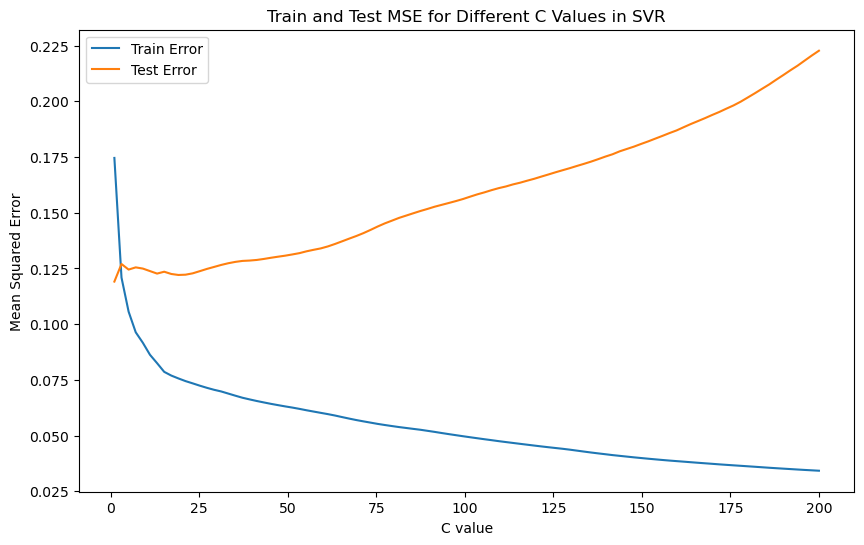

In [8]:
#Train test split
X_train, X_test, y_train, y_test = train_test_split(
        data_processed.iloc[:-lag, :-1], data_processed.iloc[:-lag, -1], test_size=0.2)

# Range of C values
C_values = np.linspace(1, 200, 100)

# Initialize lists to store the errors
train_errors = []
test_errors = []

# Loop over the range of C values
for C in C_values:
    model = SVR(C=C, epsilon=0.05, gamma = 0.03)
    model.fit(X_train, y_train)
    
    # Predict and calculate MSE for training and testing sets
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)
    
    train_errors.append(mean_squared_error(y_train, y_train_pred))
    test_errors.append(mean_squared_error(y_test, y_test_pred))

# Plotting the results
plt.figure(figsize=(10, 6))
plt.plot(C_values, train_errors, label='Train Error')
plt.plot(C_values, test_errors, label='Test Error')
plt.xlabel('C value')
plt.ylabel('Mean Squared Error')
plt.title('Train and Test MSE for Different C Values in SVR')
plt.legend()
plt.show()

Train and test errors for different C and epsilon values

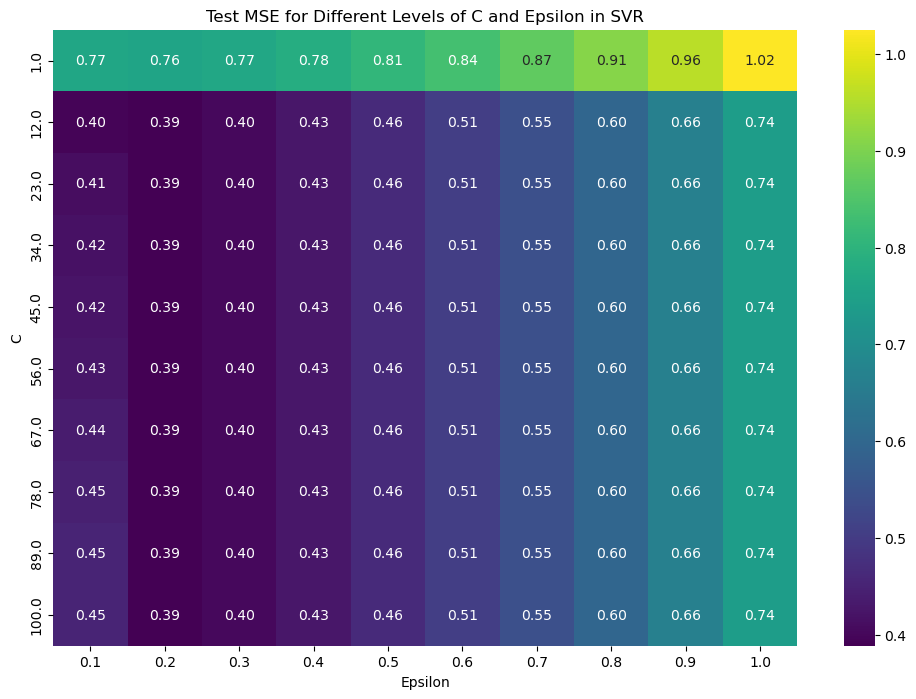

In [9]:
#Train test split
X_train, X_test, y_train, y_test = train_test_split(
        data_processed.iloc[:-lag, :-1], data_processed.iloc[:-lag, -1], test_size=0.2)

# Define ranges for C and epsilon
C_range = np.linspace(1, 100, 10)
epsilon_range = np.linspace(0.1, 1, 10)
test_errors = np.zeros((len(C_range), len(epsilon_range)))

# Loop over the ranges of C and epsilon to train models and record the test error
for i, C in enumerate(C_range):
    for j, epsilon in enumerate(epsilon_range):
        model = SVR(C=C, epsilon=epsilon, gamma = 0.2)
        model.fit(X_train, y_train)  # Using X_train without scaling as per your instruction
        y_pred = model.predict(X_test)
        test_errors[i, j] = mean_squared_error(y_test, y_pred)

# Generate the heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(test_errors, xticklabels=np.round(epsilon_range, 2), yticklabels=np.round(C_range, 2), annot=True, fmt=".2f", cmap='viridis')
plt.title('Test MSE for Different Levels of C and Epsilon in SVR')
plt.xlabel('Epsilon')
plt.ylabel('C')
plt.show()

In [10]:
prediction_data = data_processed.iloc[-lag:, :-1]

# Initialize the SVR model with specific parameters
model = SVR(C=10, epsilon=0.05, gamma=0.01)

# Preparing the data
X = data_processed.iloc[:-lag, :-1]  # input features
y = data_processed.iloc[:-lag, -1]   # target variable

# Train the model using the training dataset
model.fit(X, y)

predicted_cpi = model.predict(prediction_data)

predicted_cpi

array([3.39269487])

Good parameters

1 month ahead: gamma = 0.01, C = 10, epsilon = 0.05

3 months ahead: gamma = 0.03, C = 50, epsilon = 0.05

12 month ahead: gamma = 0.2, C = 20, epsilon = 0.05